## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import logging
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [3]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113


In [4]:
torch.cuda.is_available()


True

In [5]:
import torch
import torch.nn as nn

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example model
model = nn.Linear(10, 2)

# Move model to the device (GPU if available)
model.to(device)

# Example data
x = torch.randn(1, 10).to(device)
output = model(x)
print(output)


CUDA is available. Using GPU.
tensor([[-0.5996,  0.7109]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Load Data

In [7]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [8]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [9]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [10]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [11]:
df

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,primary_exchange,trading_status,security_status,naics,naics_sector,naics_sector_name,naics_secondary,ask_or_high_price,ask_price,bid_or_low_price,bid_price,open_price,close_price,return,volume,shares_outstanding,num_trades,factor_to_adjust_price,factor_to_adjust_shares,value_weighted_return,equal_weighted_return,return_on_SP_index,log_return,abs_log_return,market_cap,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,price_7,return_7,log_return_7,abs_log_return_7,price_14,return_14,log_return_14,abs_log_return_14,price_28,return_28,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,47.8011,46.63000,46.17000,46.62000,47.57000,46.63000,-0.013748,25380018,4139602,99,1.0,1.0,0.008505,0.011232,0.008303,-0.013843,0.013843,1.930296e+08,0.000000,0.000000,0.000000,0.000000,48.95,4.743043,0.309424,0.309424,51.12,4.231880,0.131071,0.131071,48.15,0.334682,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.0700,47.71000,47.44000,47.70000,47.53000,47.71000,0.023161,24165000,4139602,99,1.0,1.0,0.005856,0.005103,0.006399,0.022897,0.022897,1.975004e+08,0.006404,0.004872,0.005904,0.007983,49.51,2.793205,0.234088,0.234088,51.45,2.890159,0.107382,0.107382,48.49,0.157137,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.1900,48.18000,47.71500,48.17000,47.99000,48.18000,0.009851,19815057,4139602,99,1.0,1.0,0.004001,0.005272,0.004029,0.009803,0.009803,1.994460e+08,0.004048,0.000960,0.004021,0.000852,49.59,1.824771,0.183199,0.183199,51.60,2.436310,0.097613,0.097613,49.45,0.263850,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.6300,48.45000,48.28000,48.44000,48.42000,48.47000,0.006019,14496427,4139602,99,1.0,1.0,0.005804,0.003880,0.007034,0.006001,0.006001,2.006465e+08,0.009581,0.006722,0.006193,0.002919,50.27,2.716132,0.230474,0.230474,52.75,3.586591,0.120486,0.120486,50.64,0.483153,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,49.0700,48.99000,47.94000,48.98000,48.30000,48.98000,0.010522,15075007,4139602,99,1.0,1.0,0.001816,0.000584,0.001662,0.010467,0.010467,2.027577e+08,0.002142,0.005354,0.001829,0.005828,50.23,1.477412,0.161223,0.161223,51.94,1.875391,0.083731,0.083731,50.71,0.366701,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,A,R,336110.0,33,Manufacturing,6110.0,258.2200,252.53999,251.37000,252.53000,256.76001,252.53999,-0.007701,93148541,3178921,972876,1.0,1.0,0.002440,0.007676,0.001660,-0.007731,0.007731,8.028047e+08,0.000259,0.007069,0.002502,0.004469,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,A,R,336110.0,33,Manufacturing,6110.0,257.9700,256.70999,252.91000,256.66000,254.49001,256.60999,0.016116,86700724,3178921,954492,1.0,1.0,0.005218,0.009674,0.004232,0.015988,0.015988,8.157429e+08,0.007335,0.009616,0.005189,0.003873,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,

In [12]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_sector_name                         object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price           

## Feature Engineering

### Feature Selection

In [13]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
].copy()
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,-0.007731,0.007731,0.000259,0.007069,0.002502,0.004469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,0.015988,0.015988,0.007335,0.009616,0.005189,0.003873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,0.018647,0.018647,0.002344,0.001393,0.001653,0.001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,-0.032104,0.032104,-0.001451,-0.000214,-0.000266,0.002184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Standardize features and labels

In [14]:
columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]
scaler = StandardScaler()

data[columns] =scaler.fit_transform(data[columns])
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.599913,-0.077145,-0.018430,-0.009147,-0.025258,-0.017993,0.511707,0.201900,1.097317,0.702858,0.215318,-0.548049,-0.716988,-0.942127,-0.192751
9264,2018-01-03,10104,0.953274,0.423184,0.328289,0.302093,0.420004,0.618797,0.355892,0.028348,0.879456,0.403960,0.079349,-0.737177,-0.911900,-1.074948,-0.230518
9265,2018-01-04,10104,0.399725,-0.300443,0.200733,0.052181,0.277994,0.049970,0.250640,-0.088885,0.789610,0.280693,0.163295,-0.620411,-0.919385,-1.082285,-0.207312
9266,2018-01-05,10104,0.239003,-0.510547,0.500294,0.420277,0.441800,0.214851,0.348418,0.020023,0.999965,0.569295,0.316238,-0.407673,-0.853336,-0.952413,-0.167097
9267,2018-01-08,10104,0.427805,-0.263735,0.097540,0.332884,0.112680,0.446897,0.205187,-0.139512,0.661939,0.105531,0.237967,-0.516545,-0.850950,-0.800611,-0.173688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,-0.341505,-0.414949,-0.004407,0.442444,0.163436,0.338492,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
7656952,2023-12-26,93436,0.661183,0.041348,0.378694,0.605155,0.366081,0.290950,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
7656953,2023-12-27,93436,0.773615,0.188324,0.108477,0.079842,0.099407,0.074778,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
7656954,2023-12-28,93436,-1.371871,0.931997,-0.096988,-0.022818,-0.045319,0.156221,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281


### Select number of stocks

In [15]:
data['permno_id'].nunique()

554

In [16]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

In [17]:
# Filter the first n stocks
n_stocks = 100  # Adjust n as needed
data = filter_first_n_stocks(data, n_stocks)
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.599913,-0.077145,-0.018430,-0.009147,-0.025258,-0.017993,0.511707,0.201900,1.097317,0.702858,0.215318,-0.548049,-0.716988,-0.942127,-0.192751
9264,2018-01-03,10104,0.953274,0.423184,0.328289,0.302093,0.420004,0.618797,0.355892,0.028348,0.879456,0.403960,0.079349,-0.737177,-0.911900,-1.074948,-0.230518
9265,2018-01-04,10104,0.399725,-0.300443,0.200733,0.052181,0.277994,0.049970,0.250640,-0.088885,0.789610,0.280693,0.163295,-0.620411,-0.919385,-1.082285,-0.207312
9266,2018-01-05,10104,0.239003,-0.510547,0.500294,0.420277,0.441800,0.214851,0.348418,0.020023,0.999965,0.569295,0.316238,-0.407673,-0.853336,-0.952413,-0.167097
9267,2018-01-08,10104,0.427805,-0.263735,0.097540,0.332884,0.112680,0.446897,0.205187,-0.139512,0.661939,0.105531,0.237967,-0.516545,-0.850950,-0.800611,-0.173688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047724,2023-12-22,16968,-0.256767,-0.525722,0.053036,0.375942,0.163436,0.338492,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
2047725,2023-12-26,16968,0.951497,0.420861,0.101871,0.302093,0.366081,0.290950,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
2047726,2023-12-27,16968,0.125012,-0.659562,0.015354,0.307203,0.099407,0.074778,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
2047727,2023-12-28,16968,-0.136147,-0.683403,0.107286,0.057994,-0.045319,0.156221,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281


### Remove Stock with less than 1500 dates' data

In [18]:
data.groupby('permno_id').nunique()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
permno_id,,,,,,,,,,,,,,,,
10104,1509,1494,1494,1483,1490,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10107,1509,1491,1491,1482,1489,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10138,1509,1490,1490,1480,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10145,1509,1477,1477,1477,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10516,1509,1482,1482,1480,1467,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10696,1509,1477,1477,1482,1489,1482,1484,1502,1502,1496,1496,1482,1482,1502,1496,1482
10909,1117,1086,1086,1102,1105,1103,1103,1111,1111,1104,1104,1090,1090,1111,1104,1090
11308,1509,1467,1467,1480,1467,1482,1484,1502,1502,1496,1496,1481,1481,1502,1496,1481
11403,1509,1494,1494,1475,1481,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482


In [19]:
grouped_data = data.groupby('permno_id')['date'].nunique().reset_index()
grouped_data.columns = ['permno_id', 'date_count']

filtered_permno_ids = grouped_data[grouped_data['date_count'] > 1500]['permno_id']
filtered_permno_ids
data = data[data['permno_id'].isin(filtered_permno_ids)]
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.599913,-0.077145,-0.018430,-0.009147,-0.025258,-0.017993,0.511707,0.201900,1.097317,0.702858,0.215318,-0.548049,-0.716988,-0.942127,-0.192751
9264,2018-01-03,10104,0.953274,0.423184,0.328289,0.302093,0.420004,0.618797,0.355892,0.028348,0.879456,0.403960,0.079349,-0.737177,-0.911900,-1.074948,-0.230518
9265,2018-01-04,10104,0.399725,-0.300443,0.200733,0.052181,0.277994,0.049970,0.250640,-0.088885,0.789610,0.280693,0.163295,-0.620411,-0.919385,-1.082285,-0.207312
9266,2018-01-05,10104,0.239003,-0.510547,0.500294,0.420277,0.441800,0.214851,0.348418,0.020023,0.999965,0.569295,0.316238,-0.407673,-0.853336,-0.952413,-0.167097
9267,2018-01-08,10104,0.427805,-0.263735,0.097540,0.332884,0.112680,0.446897,0.205187,-0.139512,0.661939,0.105531,0.237967,-0.516545,-0.850950,-0.800611,-0.173688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047724,2023-12-22,16968,-0.256767,-0.525722,0.053036,0.375942,0.163436,0.338492,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
2047725,2023-12-26,16968,0.951497,0.420861,0.101871,0.302093,0.366081,0.290950,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
2047726,2023-12-27,16968,0.125012,-0.659562,0.015354,0.307203,0.099407,0.074778,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281
2047727,2023-12-28,16968,-0.136147,-0.683403,0.107286,0.057994,-0.045319,0.156221,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281


In [20]:
data.groupby('permno_id').nunique()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
permno_id,,,,,,,,,,,,,,,,
10104,1509,1494,1494,1483,1490,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10107,1509,1491,1491,1482,1489,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10138,1509,1490,1490,1480,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10145,1509,1477,1477,1477,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10516,1509,1482,1482,1480,1467,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10696,1509,1477,1477,1482,1489,1482,1484,1502,1502,1496,1496,1482,1482,1502,1496,1482
11308,1509,1467,1467,1480,1467,1482,1484,1502,1502,1496,1496,1481,1481,1502,1496,1481
11403,1509,1494,1494,1475,1481,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11404,1509,1472,1472,1471,1483,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482


In [21]:
# data["naics_sector_digits"] = data["naics"].astype(str).str[:2]
# data

### Add positional_encoding

In [22]:
# data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1
# data

In [23]:
def create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size):
    # Sort data by permno_id and date
    data = data.sort_values(by=["permno_id", "date"])

    # Create rolling window features for each group of permno_id
    for col in input_columns:
        for i in range(1, window_size + 1):
            data[f"{col}_past_{i}"] = data.groupby("permno_id")[col].shift(i)

    # # Add positional encoding
    # data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1

    # Drop rows with NaN values created by the shift operation
    data = data.dropna()

    return data

In [24]:
# Input parameters
input_columns = [
    "log_return",
    # "sector_weighted_avg_log_return",
    # "sector_simple_avg_log_return",
    # "weighted_avg_log_return",
    # "simple_avg_log_return",
]
target_columns = [
    "log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]

window_size = 128

In [25]:
data = create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size)
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,log_return_past_1,log_return_past_2,log_return_past_3,log_return_past_4,log_return_past_5,log_return_past_6,log_return_past_7,log_return_past_8,log_return_past_9,log_return_past_10,log_return_past_11,log_return_past_12,log_return_past_13,log_return_past_14,log_return_past_15,log_return_past_16,log_return_past_17,log_return_past_18,log_return_past_19,log_return_past_20,log_return_past_21,log_return_past_22,log_return_past_23,log_return_past_24,log_return_past_25,log_return_past_26,log_return_past_27,log_return_past_28,log_return_past_29,log_return_past_30,log_return_past_31,log_return_past_32,log_return_past_33,log_return_past_34,log_return_past_35,log_return_past_36,log_return_past_37,log_return_past_38,log_return_past_39,log_return_past_40,log_return_past_41,log_return_past_42,log_return_past_43,log_return_past_44,log_return_past_45,log_return_past_46,log_return_past_47,log_return_past_48,log_return_past_49,log_return_past_50,log_return_past_51,log_return_past_52,log_return_past_53,log_return_past_54,log_return_past_55,log_return_past_56,log_return_past_57,log_return_past_58,log_return_past_59,log_return_past_60,log_return_past_61,log_return_past_62,log_return_past_63,log_return_past_64,log_return_past_65,log_return_past_66,log_return_past_67,log_return_past_68,log_return_past_69,log_return_past_70,log_return_past_71,log_return_past_72,log_return_past_73,log_return_past_74,log_return_past_75,log_return_past_76,log_return_past_77,log_return_past_78,log_return_past_79,log_return_past_80,log_return_past_81,log_return_past_82,log_return_past_83,log_return_past_84,log_return_past_85,log_return_past_86,log_return_past_87,log_return_past_88,log_return_past_89,log_return_past_90,log_return_past_91,log_return_past_92,log_return_past_93,log_return_past_94,log_return_past_95,log_return_past_96,log_return_past_97,log_return_past_98,log_return_past_99,log_return_past_100,log_return_past_101,log_return_past_102,log_return_past_103,log_return_past_104,log_return_past_105,log_return_past_106,log_return_past_107,log_return_past_108,log_return_past_109,log_return_past_110,log_return_past_111,log_return_past_112,log_return_past_113,log_return_past_114,log_return_past_115,log_return_past_116,log_return_past_117,log_return_past_118,log_return_past_119,log_return_past_120,log_return_past_121,log_return_past_122,log_return_past_123,log_return_past_124,log_return_past_125,log_return_past_126,log_return_past_127,log_return_past_128
9391,2018-07-06,10104,0.531053,-0.128765,0.703972,0.861647,0.625893,0.224981,0.693460,0.404344,0.686261,0.138900,0.277221,-0.461943,-0.958115,-0.967099,-0.945301,0.632591,-0.231562,0.830754,0.196918,0.363080,-0.938563,0.109251,0.157528,0.954968,0.260849,-3.290483,-0.242484,0.203984,0.333866,-2.143026,-0.172030,0.212773,-0.005894,0.426341,-0.076707,0.537813,-0.184761,-0.041497,0.551580,-0.312247,0.701146,-0.685599,0.473840,-0.413181,0.465774,-0.773654,0.789877,-0.214993,-0.186926,-0.086996,-0.023734,-0.014686,-0.113895,0.301779,0.570180,-0.134155,0.316966,0.590771,-0.434780,-0.421461,0.243709,0.115109,-0.412071,0.178911,0.189094,-0.264634,-0.409724,-0.550776,-0.248817,0.364127,0.541610,0.131838,0.169189,0.234843,-0.208877,0.842770,0.051253,-1.067089,0.401274,0.565218,-0.127541,-0.704072,0.702892,-0.388948,-1.027191,1.551070,-1.040356,-1.043042,-0.041666,-4.202867,-0.274288,-0.095466,0.025709,-0.224254,-0.271183,-0.070568,0.661100,0.319105,0.165527,0.158033,0.792490,0.500911,-0.823309,-0.064727,-0.379779,0.542486,0.754025,0.121936,-0.406268,-0.703857,0.043697,0.990609,0.814093,0.282767,0.355705,0.781041,-1.808255,-0.470704,1.121516,-1.771001,-1.261091,0.018064,0.504753,-0.819949,-0.668851,0.917147,0.108366,0.257321,0.325731,0.093821,0.278863,-0.04

In [26]:
data.columns

Index(['date', 'permno_id', 'log_return', 'abs_log_return',
       'sector_weighted_avg_log_return', 'sector_simple_avg_log_return',
       'weighted_avg_log_return', 'simple_avg_log_return', 'log_return_7',
       'abs_log_return_7',
       ...
       'log_return_past_119', 'log_return_past_120', 'log_return_past_121',
       'log_return_past_122', 'log_return_past_123', 'log_return_past_124',
       'log_return_past_125', 'log_return_past_126', 'log_return_past_127',
       'log_return_past_128'],
      dtype='object', length=145)

### Check inf and missing values

In [27]:
# def check_data(df):
#     if df.isnull().values.any():
#         print("Data contains NaNs")
#     if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
#         print("Data contains Infinities")


# check_data(data)

In [28]:
data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,log_return_past_1,log_return_past_2,log_return_past_3,log_return_past_4,log_return_past_5,log_return_past_6,log_return_past_7,log_return_past_8,log_return_past_9,log_return_past_10,log_return_past_11,log_return_past_12,log_return_past_13,log_return_past_14,log_return_past_15,log_return_past_16,log_return_past_17,log_return_past_18,log_return_past_19,log_return_past_20,log_return_past_21,log_return_past_22,log_return_past_23,log_return_past_24,log_return_past_25,log_return_past_26,log_return_past_27,log_return_past_28,log_return_past_29,log_return_past_30,log_return_past_31,log_return_past_32,log_return_past_33,log_return_past_34,log_return_past_35,log_return_past_36,log_return_past_37,log_return_past_38,log_return_past_39,log_return_past_40,log_return_past_41,log_return_past_42,log_return_past_43,log_return_past_44,log_return_past_45,log_return_past_46,log_return_past_47,log_return_past_48,log_return_past_49,log_return_past_50,log_return_past_51,log_return_past_52,log_return_past_53,log_return_past_54,log_return_past_55,log_return_past_56,log_return_past_57,log_return_past_58,log_return_past_59,log_return_past_60,log_return_past_61,log_return_past_62,log_return_past_63,log_return_past_64,log_return_past_65,log_return_past_66,log_return_past_67,log_return_past_68,log_return_past_69,log_return_past_70,log_return_past_71,log_return_past_72,log_return_past_73,log_return_past_74,log_return_past_75,log_return_past_76,log_return_past_77,log_return_past_78,log_return_past_79,log_return_past_80,log_return_past_81,log_return_past_82,log_return_past_83,log_return_past_84,log_return_past_85,log_return_past_86,log_return_past_87,log_return_past_88,log_return_past_89,log_return_past_90,log_return_past_91,log_return_past_92,log_return_past_93,log_return_past_94,log_return_past_95,log_return_past_96,log_return_past_97,log_return_past_98,log_return_past_99,log_return_past_100,log_return_past_101,log_return_past_102,log_return_past_103,log_return_past_104,log_return_past_105,log_return_past_106,log_return_past_107,log_return_past_108,log_return_past_109,log_return_past_110,log_return_past_111,log_return_past_112,log_return_past_113,log_return_past_114,log_return_past_115,log_return_past_116,log_return_past_117,log_return_past_118,log_return_past_119,log_return_past_120,log_return_past_121,log_return_past_122,log_return_past_123,log_return_past_124,log_return_past_125,log_return_past_126,log_return_past_127,log_return_past_128
2047699,2023-11-16,16968,-0.394365,-0.345847,0.389793,-0.260656,-0.125864,0.310174,0.386417,0.062348,-0.254629,-0.749930,0.505474,-0.144452,-0.171786,1.439325,0.826677,-0.569918,2.143824,0.106300,1.304582,-0.558526,0.099723,4.412193,-1.361657,1.760553,-1.282998,-0.703599,1.014793,0.109925,1.003569,-0.272204,-2.833775,1.173913,-0.505845,-1.421797,-0.094915,-0.834084,-0.298115,2.041708,-1.631316,-0.115505,0.773947,0.004206,0.542319,2.048030,0.089646,0.535017,-2.184525,0.376485,0.322796,1.868646,0.355369,-1.043042,-0.324297,0.255640,-2.240990,-0.486903,-0.125083,-0.672329,-0.454810,-0.636277,-0.380803,-2.182656,1.847414,-0.042682,-0.539945,-1.307443,0.119619,1.250090,0.631051,0.911771,1.515491,-1.091366,0.301695,-1.169453,0.989164,0.388923,0.911398,-0.055628,-0.926898,-1.005590,0.323844,0.946249,-0.420991,-0.054613,-1.194658,-3.029039,-0.440032,-0.143991,0.413579,-2.668162,0.101958,1.178187,0.819233,-0.177801,-1.433687,0.840491,0.067754,-0.308713,-1.875616,0.497236,1.691341,1.083266,-0.909623,1.693940,-0.352753,-0.057575,0.633007,-1.131151,-1.117914,-0.205225,0.029510,0.816332,0.509931,1.026178,0.905318,-1.113922,0.162370,1.695807,-0.780757,-0.028047,-0.622336,1.188009,-1.074544,0.240306,0.799209,-0.032742,0.680400,-2.146271,-0.118175,1.341772,10.4

In [29]:
# data.describe().T

In [30]:
# # Check if there are any infinite values in the entire DataFrame
# infinite_values = data.isin([np.inf, -np.inf]).values.any()
# print(f"Data contains Infinities: {infinite_values}")

# # Check for specific columns
# column_with_inf = data.isin([np.inf, -np.inf]).any()
# print("Columns with Infinities:")
# print(column_with_inf[column_with_inf].index.tolist())

In [31]:
# data_inf_rows = data[(data == np.inf) | (data == -np.inf)].any(axis=1)
# data[data_inf_rows]

### Remove last 28 rows

In [32]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [33]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,log_return_past_1,log_return_past_2,log_return_past_3,log_return_past_4,log_return_past_5,log_return_past_6,log_return_past_7,log_return_past_8,log_return_past_9,log_return_past_10,log_return_past_11,log_return_past_12,log_return_past_13,log_return_past_14,log_return_past_15,log_return_past_16,log_return_past_17,log_return_past_18,log_return_past_19,log_return_past_20,log_return_past_21,log_return_past_22,log_return_past_23,log_return_past_24,log_return_past_25,log_return_past_26,log_return_past_27,log_return_past_28,log_return_past_29,log_return_past_30,log_return_past_31,log_return_past_32,log_return_past_33,log_return_past_34,log_return_past_35,log_return_past_36,log_return_past_37,log_return_past_38,log_return_past_39,log_return_past_40,log_return_past_41,log_return_past_42,log_return_past_43,log_return_past_44,log_return_past_45,log_return_past_46,log_return_past_47,log_return_past_48,log_return_past_49,log_return_past_50,log_return_past_51,log_return_past_52,log_return_past_53,log_return_past_54,log_return_past_55,log_return_past_56,log_return_past_57,log_return_past_58,log_return_past_59,log_return_past_60,log_return_past_61,log_return_past_62,log_return_past_63,log_return_past_64,log_return_past_65,log_return_past_66,log_return_past_67,log_return_past_68,log_return_past_69,log_return_past_70,log_return_past_71,log_return_past_72,log_return_past_73,log_return_past_74,log_return_past_75,log_return_past_76,log_return_past_77,log_return_past_78,log_return_past_79,log_return_past_80,log_return_past_81,log_return_past_82,log_return_past_83,log_return_past_84,log_return_past_85,log_return_past_86,log_return_past_87,log_return_past_88,log_return_past_89,log_return_past_90,log_return_past_91,log_return_past_92,log_return_past_93,log_return_past_94,log_return_past_95,log_return_past_96,log_return_past_97,log_return_past_98,log_return_past_99,log_return_past_100,log_return_past_101,log_return_past_102,log_return_past_103,log_return_past_104,log_return_past_105,log_return_past_106,log_return_past_107,log_return_past_108,log_return_past_109,log_return_past_110,log_return_past_111,log_return_past_112,log_return_past_113,log_return_past_114,log_return_past_115,log_return_past_116,log_return_past_117,log_return_past_118,log_return_past_119,log_return_past_120,log_return_past_121,log_return_past_122,log_return_past_123,log_return_past_124,log_return_past_125,log_return_past_126,log_return_past_127,log_return_past_128
129858,2023-10-09,16968,0.542319,-0.114037,0.424605,0.442636,0.393382,-0.047268,-0.117254,-0.498659,-0.860038,0.080675,0.617280,0.011066,0.612937,0.756269,1.108990,2.048030,0.089646,0.535017,-2.184525,0.376485,0.322796,1.868646,0.355369,-1.043042,-0.324297,0.255640,-2.240990,-0.486903,-0.125083,-0.672329,-0.454810,-0.636277,-0.380803,-2.182656,1.847414,-0.042682,-0.539945,-1.307443,0.119619,1.250090,0.631051,0.911771,1.515491,-1.091366,0.301695,-1.169453,0.989164,0.388923,0.911398,-0.055628,-0.926898,-1.005590,0.323844,0.946249,-0.420991,-0.054613,-1.194658,-3.029039,-0.440032,-0.143991,0.413579,-2.668162,0.101958,1.178187,0.819233,-0.177801,-1.433687,0.840491,0.067754,-0.308713,-1.875616,0.497236,1.691341,1.083266,-0.909623,1.693940,-0.352753,-0.057575,0.633007,-1.131151,-1.117914,-0.205225,0.029510,0.816332,0.509931,1.026178,0.905318,-1.113922,0.162370,1.695807,-0.780757,-0.028047,-0.622336,1.188009,-1.074544,0.240306,0.799209,-0.032742,0.680400,-2.146271,-0.118175,1.341772,10.424779,0.009784,0.190145,1.308598,-0.245289,1.087179,0.718101,-1.608262,1.213230,-2.191379,1.052197,1.049105,-0.120421,1.954640,-0.093179,0.317972,1.923196,0.555000,0.962074,0.699109,3.076698,0.473130,-1.497169,-2.591574,-0.188751,0.467028,4.733854,-2.153697,-1.662117,1.

In [34]:
# cleaned_data.isnull().sum()

In [35]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
# train_data = data[data["date"] <= "2022-12-31"]
# validation_data = data[data["date"] > "2022-12-31"]
# train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
# validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

In [36]:
# train_data

In [37]:
# validation_data

## Model
1. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
2. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

### Cases: 4 dimensions input

In [38]:
cleaned_data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,log_return_past_1,log_return_past_2,log_return_past_3,log_return_past_4,log_return_past_5,log_return_past_6,log_return_past_7,log_return_past_8,log_return_past_9,log_return_past_10,log_return_past_11,log_return_past_12,log_return_past_13,log_return_past_14,log_return_past_15,log_return_past_16,log_return_past_17,log_return_past_18,log_return_past_19,log_return_past_20,log_return_past_21,log_return_past_22,log_return_past_23,log_return_past_24,log_return_past_25,log_return_past_26,log_return_past_27,log_return_past_28,log_return_past_29,log_return_past_30,log_return_past_31,log_return_past_32,log_return_past_33,log_return_past_34,log_return_past_35,log_return_past_36,log_return_past_37,log_return_past_38,log_return_past_39,log_return_past_40,log_return_past_41,log_return_past_42,log_return_past_43,log_return_past_44,log_return_past_45,log_return_past_46,log_return_past_47,log_return_past_48,log_return_past_49,log_return_past_50,log_return_past_51,log_return_past_52,log_return_past_53,log_return_past_54,log_return_past_55,log_return_past_56,log_return_past_57,log_return_past_58,log_return_past_59,log_return_past_60,log_return_past_61,log_return_past_62,log_return_past_63,log_return_past_64,log_return_past_65,log_return_past_66,log_return_past_67,log_return_past_68,log_return_past_69,log_return_past_70,log_return_past_71,log_return_past_72,log_return_past_73,log_return_past_74,log_return_past_75,log_return_past_76,log_return_past_77,log_return_past_78,log_return_past_79,log_return_past_80,log_return_past_81,log_return_past_82,log_return_past_83,log_return_past_84,log_return_past_85,log_return_past_86,log_return_past_87,log_return_past_88,log_return_past_89,log_return_past_90,log_return_past_91,log_return_past_92,log_return_past_93,log_return_past_94,log_return_past_95,log_return_past_96,log_return_past_97,log_return_past_98,log_return_past_99,log_return_past_100,log_return_past_101,log_return_past_102,log_return_past_103,log_return_past_104,log_return_past_105,log_return_past_106,log_return_past_107,log_return_past_108,log_return_past_109,log_return_past_110,log_return_past_111,log_return_past_112,log_return_past_113,log_return_past_114,log_return_past_115,log_return_past_116,log_return_past_117,log_return_past_118,log_return_past_119,log_return_past_120,log_return_past_121,log_return_past_122,log_return_past_123,log_return_past_124,log_return_past_125,log_return_past_126,log_return_past_127,log_return_past_128
0,2018-07-06,10104,0.531053,-0.128765,0.703972,0.861647,0.625893,0.224981,0.693460,0.404344,0.686261,0.138900,0.277221,-0.461943,-0.958115,-0.967099,-0.945301,0.632591,-0.231562,0.830754,0.196918,0.363080,-0.938563,0.109251,0.157528,0.954968,0.260849,-3.290483,-0.242484,0.203984,0.333866,-2.143026,-0.172030,0.212773,-0.005894,0.426341,-0.076707,0.537813,-0.184761,-0.041497,0.551580,-0.312247,0.701146,-0.685599,0.473840,-0.413181,0.465774,-0.773654,0.789877,-0.214993,-0.186926,-0.086996,-0.023734,-0.014686,-0.113895,0.301779,0.570180,-0.134155,0.316966,0.590771,-0.434780,-0.421461,0.243709,0.115109,-0.412071,0.178911,0.189094,-0.264634,-0.409724,-0.550776,-0.248817,0.364127,0.541610,0.131838,0.169189,0.234843,-0.208877,0.842770,0.051253,-1.067089,0.401274,0.565218,-0.127541,-0.704072,0.702892,-0.388948,-1.027191,1.551070,-1.040356,-1.043042,-0.041666,-4.202867,-0.274288,-0.095466,0.025709,-0.224254,-0.271183,-0.070568,0.661100,0.319105,0.165527,0.158033,0.792490,0.500911,-0.823309,-0.064727,-0.379779,0.542486,0.754025,0.121936,-0.406268,-0.703857,0.043697,0.990609,0.814093,0.282767,0.355705,0.781041,-1.808255,-0.470704,1.121516,-1.771001,-1.261091,0.018064,0.504753,-0.819949,-0.668851,0.917147,0.108366,0.257321,0.325731,0.093821,0.278863,-0.04835

In [39]:
cleaned_data['permno_id'].nunique()

96

In [40]:
cleaned_data.groupby('permno_id')['date'].count()

permno_id
10104    1353
10107    1353
10138    1353
10145    1353
10516    1353
10696    1353
11308    1353
11403    1353
11404    1353
11600    1353
11618    1353
11674    1353
11691    1353
11762    1353
11850    1353
11891    1353
11955    1353
12036    1353
12052    1353
12060    1353
12062    1353
12084    1353
12308    1353
12345    1353
12369    1353
12431    1353
12449    1353
12476    1353
12490    1353
12558    1353
12622    1353
12623    1353
12872    1353
13035    1353
13103    1353
13168    1353
13210    1353
13323    1353
13356    1353
13379    1353
13407    1353
13447    1353
13511    1353
13586    1353
13628    1353
13641    1353
13688    1353
13721    1353
13757    1353
13760    1353
13788    1353
13856    1353
13901    1353
13911    1353
13928    1353
13949    1353
13963    1353
13964    1353
14008    1353
14277    1353
14297    1353
14338    1353
14541    1353
14542    1353
14579    1353
14593    1353
14702    1353
14714    1353
14763    1353
14776    1353
14811    1

#### Standardize features and labels

In [41]:
# from sklearn.preprocessing import StandardScaler

# # Copy the cleaned_data to standardized_data
# standardized_data = cleaned_data.copy()

# # List of columns to exclude from standardization
# exclude_columns = ['date', 'permno_id']

# # Extract the columns to be standardized
# columns_to_standardize = [col for col in standardized_data.columns if col not in exclude_columns]

# # Create a StandardScaler instance
# scaler = StandardScaler()

# # Standardize the selected columns
# standardized_data[columns_to_standardize] = scaler.fit_transform(standardized_data[columns_to_standardize])

# standardized_data


In [42]:
# standardized_data[standardized_data['permno_id']=='10104']

#### Create Dataset

In [43]:
# class FinancialDataset(Dataset):
#     def __init__(self, data):
#         self.data = data
#         self.target_columns = [
#             "log_return",
#             "abs_log_return",
#             "log_return_7",
#             "abs_log_return_7",
#             "log_return_14",
#             "abs_log_return_14",
#             "log_return_28",
#             "abs_log_return_28",
#             "volatility_7",
#             "volatility_14",
#             "volatility_28",
#         ]
#         self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
#         self.data = self.data.dropna()

#         # Group by permno_id
#         self.groups = self.data.groupby(["date"])
#         self.sequences = []

#         for name, group in self.groups:
#             X = group.drop(columns=[
#                 "date",
#                 "permno_id",
#                 "sector_weighted_avg_log_return",
#                 "sector_simple_avg_log_return",
#                 "weighted_avg_log_return",
#                 "simple_avg_log_return",
#             ] + self.target_columns)

#             X = X.apply(pd.to_numeric, errors="coerce").values
#             X = X.T

#             y = group[self.target_columns].values
#             self.sequences.append((X, y))

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         X, y = self.sequences[idx]
#         return {
#             "features": torch.tensor(X, dtype=torch.float),
#             "target": torch.tensor(y, dtype=torch.float),
#             #"permno_id": permno_id,
#         }

In [44]:
class FinancialDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28",
        ]
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        self.data = self.data.dropna()

        # self.one_hot_encoder = one_hot_encoder
        # if self.one_hot_encoder is None:
        #     self.one_hot_encoder = OneHotEncoder(sparse_output=False)
        #     self.data["permno_id"] = self.data["permno_id"].astype(str)
        #     self.permno_one_hot = self.one_hot_encoder.fit_transform(self.data[["permno_id"]].to_numpy().reshape(-1, 1))
        # else:
        #     self.data["permno_id"] = self.data["permno_id"].astype(str)
        #     self.permno_one_hot = self.one_hot_encoder.transform(self.data[["permno_id"]].to_numpy().reshape(-1, 1))

        #Create a Pandas DataFrame of the hot encoded column
        # ohe_df = pd.DataFrame(self.permno_one_hot, columns=self.one_hot_encoder.get_feature_names_out())
        # #concat with original data
        # self.data = pd.concat([self.data, ohe_df], axis=1)
        # print(self.data.columns)
        # print(self.one_hot_encoder.get_feature_names_out())
        # print(self.data.shape)
        
        # Group by permno_id
        self.groups = self.data.groupby(["date"])
        self.sequences = []

        for name, group in self.groups:
            # print(f"date: {name}")
            one_hot_columns = [f"permno_id_{col}" for col in list(group["permno_id"].unique())]
            # print(one_hot_columns)
            #one_hot_array = group[one_hot_columns].values
            X = group.drop(columns=[
                "date",
                "permno_id",
                "sector_weighted_avg_log_return",
                "sector_simple_avg_log_return",
                "weighted_avg_log_return",
                "simple_avg_log_return",
                "abs_log_return",
                "log_return_7",
                "abs_log_return_7",
                "log_return_14",
                "abs_log_return_14",
                "log_return_28",
                "abs_log_return_28",
                "volatility_7",
                "volatility_14",
                "volatility_28",
            ] + self.target_columns + one_hot_columns)

            X = X.apply(pd.to_numeric, errors="coerce").values
            X = X.T
            
            for stock in list(group["permno_id"].unique()):

                features = np.copy(X)
                #print(features.shape)
                subsample = group.loc[group["permno_id"] == stock]
                # print(stock)
                # print(subsample.shape)
                single_one_hot = subsample[one_hot_columns].values
                # print(single_one_hot)
                single_one_hot = np.tile(single_one_hot, (128, 1))
                # print(f'onehot: {single_one_hot.shape}')
                features = np.concatenate(
                        [features, single_one_hot], axis=1
                    )

                # print(features.shape)
                y = subsample[self.target_columns].values
                y = y.T.squeeze()
                # y = y.T
                self.sequences.append((features, y, stock))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        features, y, stock = self.sequences[idx]
        #print(features)
        return {
            "features": torch.tensor(features, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": stock,
        }

#### Train 100 Stocks

In [45]:
standardized_data = cleaned_data.copy()

In [46]:
%%time
# Prepare Data 
#standardized_data["permno_id"] = standardized_data["permno_id"].astype(str)

standardized_data["permno_id"] = standardized_data["permno_id"].astype(str)
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# one_hot_encoder.fit(standardized_data[["permno_id"]])

# Ensure the data is sorted by date for each permno_id
standardized_data = standardized_data.sort_values(by=["date", "permno_id"])
dummies = pd.get_dummies(standardized_data["permno_id"], prefix = "permno_id") * 1
standardized_data = pd.concat([standardized_data, dummies], axis = 1)

# # Filter the first n stocks
# n_stocks = 10  # Adjust n as needed
# standardized_data_n_stocks = filter_first_n_stocks(standardized_data, n_stocks)
standardized_data_n_stocks = standardized_data.copy()

# Split data
train_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] <= "2023-09-30"]
validation_data = standardized_data_n_stocks[standardized_data_n_stocks["date"] > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_data.groupby("permno_id").tail(128)

# Include these rows in validation_data
validation_data = pd.concat([last_128_rows, validation_data]).drop_duplicates().reset_index(drop=True)

# Create datasets
# train_dataset = FinancialDataset(train_data, n_stocks=n_stocks)
# val_dataset = FinancialDataset(validation_data, n_stocks=n_stocks)

train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# # Fetch a single item to check correctness
# sample_item = train_dataset[0]
# print(sample_item)

Train Dataset Length: 126528
Validation Dataset Length: 15648
CPU times: user 2min 17s, sys: 9.65 s, total: 2min 26s
Wall time: 2min 26s


In [47]:
for batch in train_dataloader:
    print(batch["features"].shape)
    # break

torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
torch.Size([64, 128, 192])
t

In [48]:
batch["features"].shape

torch.Size([64, 128, 192])

In [49]:
batch["target"].shape

torch.Size([64])

#### 1-Origninal Model

In [50]:
stock_number = cleaned_data['permno_id'].nunique()
stock_number

96

#### Build and Train Model

In [51]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc2 = nn.Linear(128, input_dim)

    def forward(self, x):
        # print(x.shape)
        # x = x.transpose(1,2)
        x = self.input_embedding(x)
        # print(x.shape)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        # print(x.shape)
        # input_embedding = x
        x = self.transformer(x)
        # print(x.shape)
        output_embedding = x[-1, :, :]  # Get the last output token
        # output_embedding = x
        # print(output_embedding.shape)
        x = self.hidden_layers(output_embedding)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        # x = x.transpose(0, 2)
        # # print(x.shape)
        # x = self.fc2(x)
        # # print(x.shape)
        # x = x.transpose(0, 2)
        # x = x.transpose(0, 1)
        # print(x.shape)
        
        return x, output_embedding

Starting Training...
Batch 0/1977, Loss: 0.4709, Estimated time left for epoch: 00:02:25, Estimated time left for training: 00:48:38
Batch 100/1977, Loss: 1.0391, Estimated time left for epoch: 00:00:24, Estimated time left for training: 00:08:34
Batch 200/1977, Loss: 0.4269, Estimated time left for epoch: 00:00:22, Estimated time left for training: 00:08:19
Batch 300/1977, Loss: 0.3856, Estimated time left for epoch: 00:00:21, Estimated time left for training: 00:08:13
Batch 400/1977, Loss: 0.6415, Estimated time left for epoch: 00:00:19, Estimated time left for training: 00:08:09
Batch 500/1977, Loss: 0.7650, Estimated time left for epoch: 00:00:18, Estimated time left for training: 00:08:07
Batch 600/1977, Loss: 0.5512, Estimated time left for epoch: 00:00:17, Estimated time left for training: 00:08:04
Batch 700/1977, Loss: 1.1302, Estimated time left for epoch: 00:00:15, Estimated time left for training: 00:08:02
Batch 800/1977, Loss: 0.6069, Estimated time left for epoch: 00:00:14

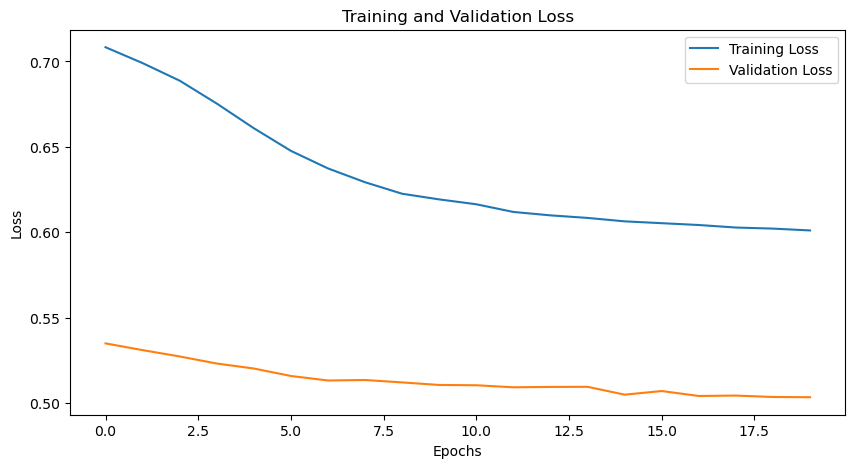

CPU times: user 8min 37s, sys: 5.04 s, total: 8min 42s
Wall time: 8min 35s


In [52]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
# input_dim = 128*5+1
input_dim = stock_number+stock_number
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=1,
    # output_dim=len(train_dataset.target_columns),
    output_dim=1,
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 20
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Plot Prediction vs True Values (scaler.inverse_transform)

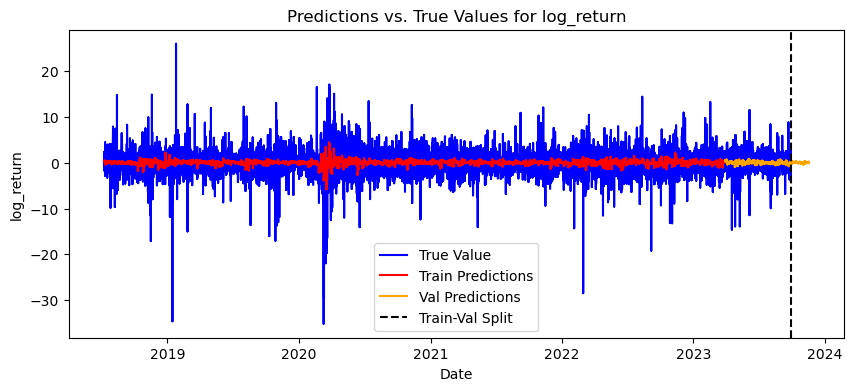

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Assuming the model and dataloaders are already defined and trained
# Also assuming the standardized_data is available

# Separate scaler for target columns
target_scaler = StandardScaler()
standardized_data[train_dataset.target_columns] = target_scaler.fit_transform(standardized_data[train_dataset.target_columns])

# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            # print(output.shape)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Inverse transform the predictions and true values using target_scaler
train_predictions = target_scaler.inverse_transform(train_predictions)
train_true_values = target_scaler.inverse_transform(train_true_values)
val_predictions = target_scaler.inverse_transform(val_predictions)
val_true_values = target_scaler.inverse_transform(val_true_values)

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
train_dates = train_data.iloc[window_size:len(train_predictions) + window_size]['date'].values
if len(train_dates) < len(train_predictions_df):
    train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
train_predictions_df['date'] = train_dates
train_true_values_df['date'] = train_dates

val_dates = validation_data.iloc[window_size:len(val_predictions) + window_size]['date'].values
if len(val_dates) < len(val_predictions_df):
    val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
val_predictions_df['date'] = val_dates
val_true_values_df['date'] = val_dates

# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df['date'], train_true_values_df[label], label='True Value', color='blue')

    plt.plot(train_predictions_df['date'], train_predictions_df[label], label='Train Predictions', color='red')
    plt.plot(val_predictions_df['date'], val_predictions_df[label], label='Val Predictions', color='orange')

    plt.axvline(x=pd.to_datetime('2023-09-30'), color='black', linestyle='--', label='Train-Val Split')

    plt.xlabel('Date')
    plt.ylabel(label)
    plt.title(f'Predictions vs. True Values for {label}')
    plt.legend()
    plt.show()

# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)


#### Input Embedding Weights

In [54]:
input_embedding_weights = model.input_embedding.weight.detach().cpu().numpy().T
print(input_embedding_weights)

[[-0.05100896  0.0448534  -0.05014171 ...  0.06113314 -0.06734654
   0.05375739]
 [ 0.07799814 -0.07229506  0.01241603 ...  0.05237043  0.05344608
   0.05305829]
 [ 0.06823387 -0.03166412 -0.00914296 ...  0.05860701 -0.00532927
  -0.03385283]
 ...
 [ 0.00231978  0.02939473 -0.0225284  ... -0.02634443  0.0339717
  -0.0480135 ]
 [-0.02134204  0.02140849  0.00199923 ... -0.01104085 -0.00896132
  -0.01567106]
 [-0.02354233 -0.02984597  0.01662303 ... -0.05425868  0.01020409
   0.01100074]]


In [55]:
input_embedding_weights.shape

(192, 256)

In [56]:
cosine_sim_matrix_input_embedding_weights = cosine_similarity(input_embedding_weights)
cosine_sim_matrix_input_embedding_weights

array([[ 0.99999994, -0.04104681, -0.08043274, ...,  0.00510429,
        -0.0910976 ,  0.01769952],
       [-0.04104681,  0.9999999 , -0.02725857, ..., -0.01141894,
         0.08532461,  0.06797615],
       [-0.08043274, -0.02725857,  1.        , ..., -0.07153516,
        -0.1578696 , -0.08562024],
       ...,
       [ 0.00510429, -0.01141894, -0.07153516, ...,  1.0000001 ,
         0.1388572 ,  0.20129265],
       [-0.0910976 ,  0.08532461, -0.1578696 , ...,  0.1388572 ,
         0.99999994,  0.19942123],
       [ 0.01769952,  0.06797615, -0.08562024, ...,  0.20129265,
         0.19942123,  1.0000001 ]], dtype=float32)

In [57]:
pd.DataFrame(cosine_sim_matrix_input_embedding_weights).to_csv("cosine_sim_matrix_input_embedding_weights_100_2.csv")

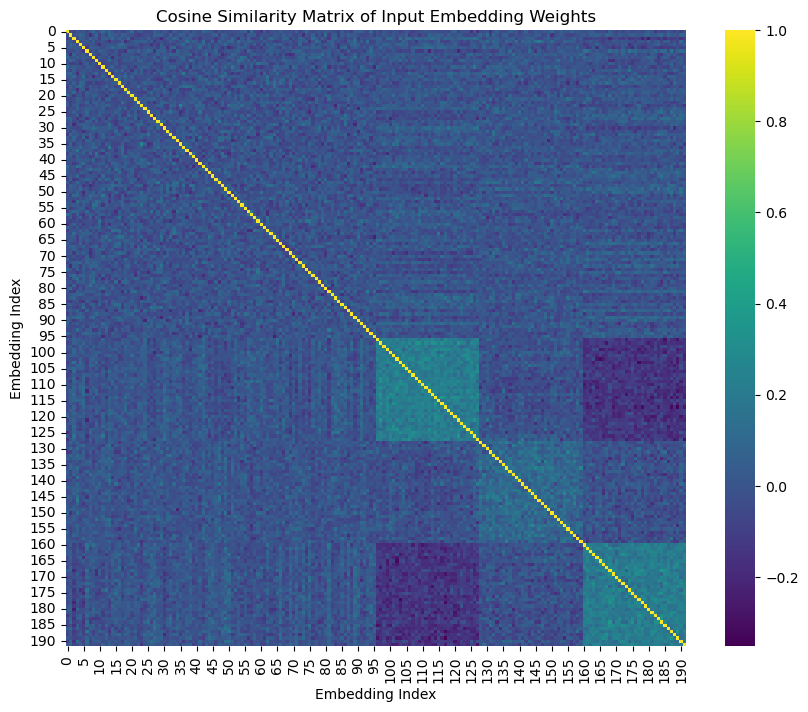

In [58]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_input_embedding_weights, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix of Input Embedding Weights')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

In [59]:
# fc_weights = model.fc.weight.detach().cpu().numpy()
# print(fc_weights)

In [60]:
# fc_weights.shape

In [61]:
# cosine_sim_matrix_fc_weights = cosine_similarity(fc_weights)
# cosine_sim_matrix_fc_weights

In [62]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_sim_matrix_fc_weights, annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Input Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()

#### Feed_Forward Weights

In [63]:
# # To get the weights of the first encoder layer
# encoder_layer_weights = model.transformer.layers[0].state_dict()
# encoder_layer_weights

In [64]:
# # If you want to get the weights of all encoder layers
# all_encoder_layers_weights = [layer.state_dict() for layer in model.transformer.layers]
# all_encoder_layers_weights

In [65]:
# # Attention weights
# attention_weights = encoder_layer_weights['self_attn.in_proj_weight']

# # Feedforward weights
# feedforward_weights = encoder_layer_weights['linear1.weight']

# print("Attention Weights:", attention_weights.shape)
# print("Feedforward Weights:", feedforward_weights.shape)


In [66]:
# feedforward_weights_matrix = feedforward_weights.cpu().numpy()
# feedforward_weights_matrix

In [67]:
# cosine_sim_matrix_feedforward_weights = cosine_similarity(feedforward_weights_matrix)
# cosine_sim_matrix_feedforward_weights

In [68]:
# # Plot the cosine similarity matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_sim_matrix_feedforward_weights, annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Input Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()

#### Extract Last Output Embedding

In [69]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            stock_embeddings[permno_id] = embeddings[i].cpu().numpy()  # Keep only the last embedding

In [70]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 2.13 ms, sys: 60 μs, total: 2.19 ms
Wall time: 1.58 ms


array([[1.0000002 , 0.97815025, 0.98067373, ..., 0.8673971 , 0.8785803 ,
        0.87098324],
       [0.97815025, 0.9999994 , 0.9773755 , ..., 0.8627178 , 0.8712712 ,
        0.86329067],
       [0.98067373, 0.9773755 , 1.        , ..., 0.87325114, 0.8831813 ,
        0.8741926 ],
       ...,
       [0.8673971 , 0.8627178 , 0.87325114, ..., 1.        , 0.9778667 ,
        0.9798977 ],
       [0.8785803 , 0.8712712 , 0.8831813 , ..., 0.9778667 , 1.0000001 ,
        0.97883046],
       [0.87098324, 0.86329067, 0.8741926 , ..., 0.9798977 , 0.97883046,
        0.9999999 ]], dtype=float32)

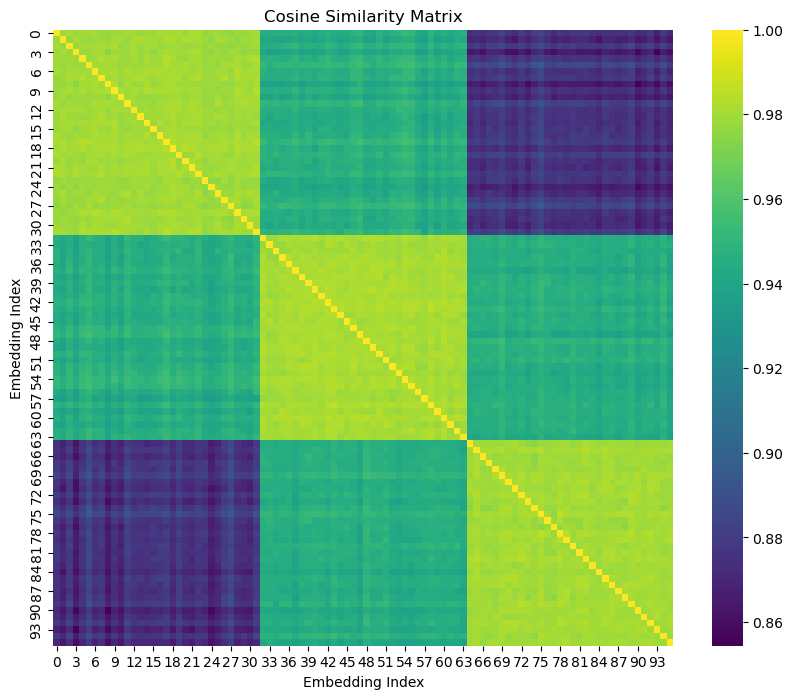

In [71]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

In [72]:
pd.DataFrame(cosine_sim_matrix).to_csv("cosine_sim_matrix_100_2.csv")

In [73]:

# with torch.no_grad():
#     for batch in train_dataloader:
#         _, embeddings = model(batch["features"].to(device))

In [74]:
# # output_embedding_matrix = embeddings[:,-1,:].cpu().numpy()
# output_embedding_matrix = embeddings.cpu().numpy()
# output_embedding_matrix

In [75]:
# output_embedding_matrix.shape

In [76]:
# cosine_sim_matrix_out_embedding = cosine_similarity(output_embedding_matrix)
# cosine_sim_matrix_out_embedding

In [77]:
# # Plot the cosine similarity matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_sim_matrix_out_embedding, annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Output Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()

#### Average Output Embedding

In [78]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

CPU times: user 13.1 s, sys: 83.3 ms, total: 13.1 s
Wall time: 13.1 s


In [79]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

CPU times: user 239 ms, sys: 3.96 ms, total: 243 ms
Wall time: 242 ms


In [80]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.45 ms


array([[1.0000005 , 0.96836805, 0.97254914, ..., 0.7798115 , 0.8005115 ,
        0.7903903 ],
       [0.96836805, 1.0000004 , 0.96704495, ..., 0.7705406 , 0.78670985,
        0.7769564 ],
       [0.97254914, 0.96704495, 0.99999976, ..., 0.7892237 , 0.80661577,
        0.79559475],
       ...,
       [0.7798115 , 0.7705406 , 0.7892237 , ..., 0.99999964, 0.9642051 ,
        0.96873087],
       [0.8005115 , 0.78670985, 0.80661577, ..., 0.9642051 , 1.        ,
        0.96640116],
       [0.7903903 , 0.7769564 , 0.79559475, ..., 0.96873087, 0.96640116,
        1.        ]], dtype=float32)

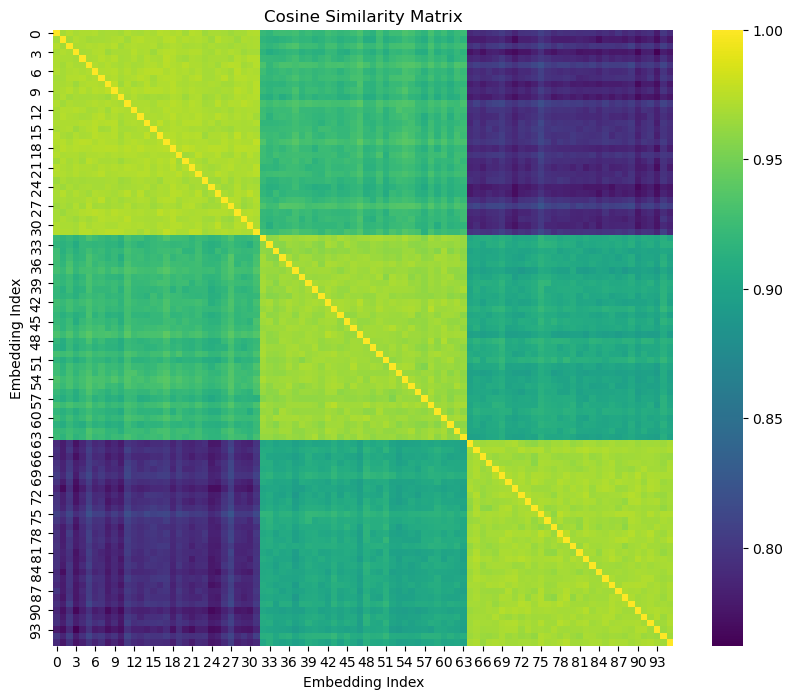

In [81]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, annot=False, cmap='viridis')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')
plt.show()

In [82]:
# # Initialize an empty tensor to accumulate the embeddings
# accumulated_embeddings = torch.zeros(128, 256).to(device)
# total_batches = 0

# with torch.no_grad():
#     for batch in train_dataloader:
#         _, embeddings = model(batch["features"].to(device))
#         #print(embeddings)
#         accumulated_embeddings += embeddings.sum(dim=1)
#         # total_batches += batch["features"].size(0)
#         total_batches += embeddings.size(1)

# # Divide the accumulated embeddings by the total number of batches to get the average
# average_embeddings = accumulated_embeddings / total_batches
# print(total_batches)
# average_embeddings

In [83]:
# average_embeddings.shape

In [84]:
# batch["features"].shape

In [85]:
# batch["features"].size(0)

In [86]:
# # Plot the cosine similarity matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_similarity(average_embeddings.cpu().numpy()), annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Input Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()